## Library import

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

## Data loads

In [286]:
data = pd.read_csv('samsung.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-06,28860.0,29800.0,28700.0,29400.0,285.111786,10582600.0
1,2015-04-07,29560.0,29700.0,29240.0,29240.0,283.560150,9526050.0
2,2015-04-08,29400.0,29700.0,29200.0,29580.0,286.857361,7773400.0
3,2015-04-09,29400.0,29780.0,29400.0,29660.0,287.633209,9107550.0
4,2015-04-10,29600.0,29880.0,29560.0,29800.0,288.990875,9960100.0


## Data pre-processing

In [287]:
# 결측치 제거
dataset = data.dropna()

In [288]:
# compute mid price
high_prices = dataset['High'].values
low_prices = dataset['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [289]:
mid_prices

array([29250., 29470., 29450., ..., 53200., 52100., 47075.])

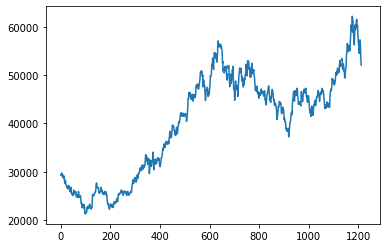

In [290]:
plt.plot(mid_prices_li)

In [291]:
# create windows
# 최근 50일간의 데이터를 확인하여 내일을 예측
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [292]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
# shuffle을 해도, 51개의 묶음은 변하지 않으므로 상관없음
# 50일(x)로 1일(y) 예측
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1041, 50, 1), (116, 50, 1))

## Model build

In [293]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(32, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_28 (LSTM)               (None, 32)                10624     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


## Training

In [294]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=10)

Train on 1041 samples, validate on 116 samples
Epoch 1/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.7853 - val_loss: 0.4800
Epoch 2/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.3773 - val_loss: 0.1738
Epoch 3/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1951 - val_loss: 0.1174
Epoch 4/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1627 - val_loss: 0.1205
Epoch 5/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1551 - val_loss: 0.1086
Epoch 6/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1492 - val_loss: 0.1137
Epoch 7/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1500 - val_loss: 0.1173
Epoch 8/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1507 - val_loss: 0.1118
Epoch 9/10
1041/1041 [==============================] - 3s 3ms/step - loss: 0.1482 - val_loss: 0.1224
Epoch 10/10
1041/1041 [============

## Prediction & Evaluation

In [223]:
pred = model.predict(x_test)

In [224]:
# 복원
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

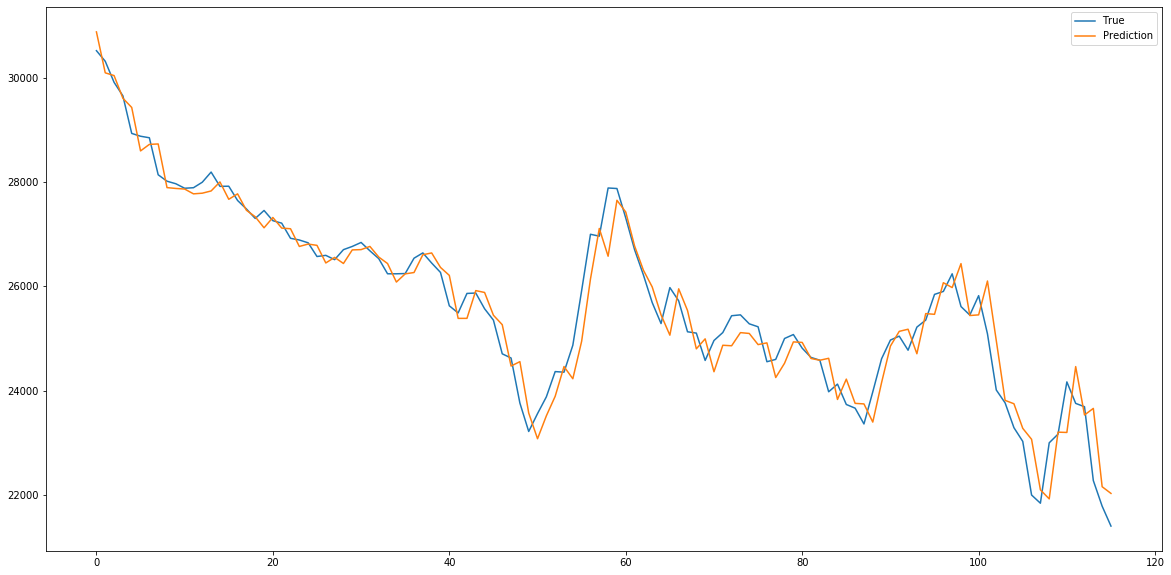

In [226]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_y, label='True')
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()

## Model test

In [328]:
lt = mid_prices[-365:]
len(lt)

365

In [342]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(lt) - sequence_length):
    result.append(lt[index: index + sequence_length])

In [343]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

x_test = result[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[:, -1]

x_test.shape

(314, 50, 1)

In [344]:
pred = model.predict(x_test)

In [345]:
# 복원
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

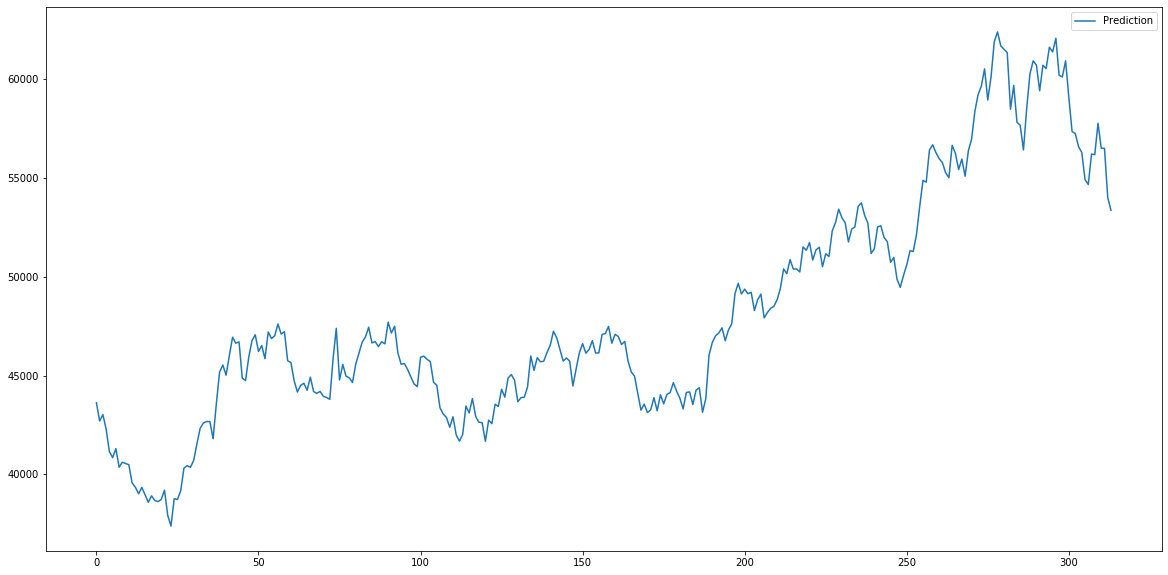

2020년 4월 2일의 주가는 56501.53
2020년 4월 3일의 주가는 54018.97
2020년 4월 4일의 주가는 53361.23


In [357]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()

print('2020년 4월 2일의 주가는', '%0.2f'%float(pred_result[-3]))
print('2020년 4월 3일의 주가는', '%0.2f'%float(pred_result[-2]))
print('2020년 4월 4일의 주가는', '%0.2f'%float(pred_result[-1]))